In [1]:
%cd C:\Users\John\Documents\Research\ML_Gravity\

C:\Users\John\Documents\Research\ML_Gravity


In [2]:
import os

os.environ["PATH"] += os.pathsep + "C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1\\extras\\CUPTI\\lib64"

import copy
import pickle
import sys
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from GravNN.CelestialBodies.Asteroids import Bennu, Eros
from GravNN.CelestialBodies.Planets import Earth
from GravNN.Networks.Configs.Default_Configs import *
from GravNN.Networks.Configs.Fast_Configs import *
from GravNN.GravityModels.Polyhedral import Polyhedral, get_poly_data
from GravNN.GravityModels.SphericalHarmonics import (SphericalHarmonics,
                                                     get_sh_data)
from GravNN.Networks import utils
from GravNN.Networks.Analysis import Analysis
from GravNN.Networks.Callbacks import CustomCallback
from GravNN.Networks.Compression import (cluster_model, prune_model,
                                         quantize_model)
from GravNN.Networks.Data import generate_dataset, training_validation_split
from GravNN.Networks.Model import CustomModel, load_config_and_model
from GravNN.Networks.Networks import (DenseNet, InceptionNet, ResNet,
                                      TraditionalNet)
from GravNN.Networks.Plotting import Plotting
from GravNN.Support.Grid import Grid
from GravNN.Support.transformations import (cart2sph, project_acceleration,
                                            sphere2cart)
from GravNN.Trajectories.DHGridDist import DHGridDist
from GravNN.Trajectories.ExponentialDist import ExponentialDist
from GravNN.Trajectories.GaussianDist import GaussianDist
from GravNN.Trajectories.RandomAsteroidDist import RandomAsteroidDist
from GravNN.Trajectories.RandomDist import RandomDist
from GravNN.Trajectories.FibonacciDist import FibonacciDist

from GravNN.Trajectories.ReducedGridDist import ReducedGridDist
from GravNN.Trajectories.ReducedRandDist import ReducedRandDist
from GravNN.Visualization.MapVisualization import MapVisualization
from GravNN.Visualization.VisualizationBase import VisualizationBase
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from GravNN.Networks.Activations import leaky_relu, bent_identity
from Scripts.Networks.train import train_network
from Scripts.Networks.plot import Plotting

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# TODO: Put in mixed precision training
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

# https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

np.random.seed(1234)
tf.random.set_seed(0)

planet = Earth()
density_deg = 180
test_trajectories = {

    "Brillouin" : DHGridDist(planet, planet.radius, degree=density_deg),
}
points = 64800
planet = Earth()
analysis_trajectories = {
    "Brillouin" : FibonacciDist(planet, planet.radius, points),
    #"LEO" : FibonacciDist(planet, planet.radius+420000.0, points),
}
def pipeline(df_file, config):
    model, config = train_network(df_file, config)

    analyzer = Analysis(model, config)
    model_id = config['id'][0]
    rse_entries = analyzer.compute_rse_stats(analysis_trajectories)
    utils.update_df_row(model_id, df_file, rse_entries)
    print(rse_entries['Brillouin_param_rse_mean'])
    print(rse_entries['Brillouin_rse_mean'])

    print(rse_entries['Brillouin_param_sigma_2_mean'])
    print(rse_entries['Brillouin_sigma_2_mean'])

    plotter = Plotting(model, config)
    plotter.plot_loss()

67
Epoch: 6950 	 Loss: 0.00111 	 Val Loss 0.00109 	 Time: 1.051
Epoch: 6960 	 Loss: 0.00111 	 Val Loss 0.00110 	 Time: 1.058
Epoch: 6970 	 Loss: 0.00110 	 Val Loss 0.00111 	 Time: 1.063
Epoch: 6980 	 Loss: 0.00110 	 Val Loss 0.00108 	 Time: 1.079
Epoch: 6990 	 Loss: 0.00110 	 Val Loss 0.00109 	 Time: 1.108
Epoch: 7000 	 Loss: 0.00110 	 Val Loss 0.00109 	 Time: 1.030
Epoch: 7010 	 Loss: 0.00110 	 Val Loss 0.00108 	 Time: 1.074
Epoch: 7020 	 Loss: 0.00110 	 Val Loss 0.00108 	 Time: 1.044
Epoch: 7030 	 Loss: 0.00110 	 Val Loss 0.00108 	 Time: 1.034
Epoch: 7040 	 Loss: 0.00110 	 Val Loss 0.00109 	 Time: 1.045
Epoch: 7050 	 Loss: 0.00110 	 Val Loss 0.00109 	 Time: 1.053
Epoch: 7060 	 Loss: 0.00110 	 Val Loss 0.00109 	 Time: 1.018
Epoch: 7070 	 Loss: 0.00111 	 Val Loss 0.00108 	 Time: 1.053
Epoch: 7080 	 Loss: 0.00110 	 Val Loss 0.00107 	 Time: 1.040
Epoch: 7090 	 Loss: 0.00111 	 Val Loss 0.00109 	 Time: 1.042
Epoch: 7100 	 Loss: 0.00110 	 Val Loss 0.00111 	 Time: 1.046
Epoch: 7110 	 Loss: 0

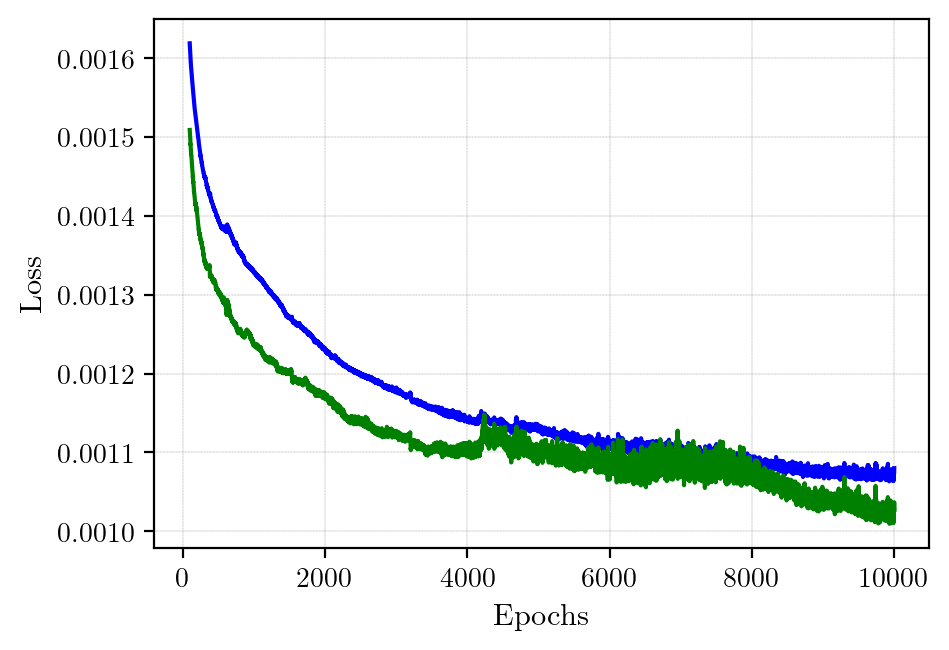

In [4]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [10000]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['activation'] = [leaky_relu(act_slope=0.05)]
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)


#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [10000]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['PINN_flag'] = ['gradient']
config['activation'] = [leaky_relu(act_slope=0.05)]
config['mixed_precision'] = [False]
pipeline(df_file, config)

 0.00076 	 Time: 1.343
Epoch: 6830 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.354
Epoch: 6840 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.387
Epoch: 6850 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.386
Epoch: 6860 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.253
Epoch: 6870 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.316
Epoch: 6880 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.369
Epoch: 6890 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.418
Epoch: 6900 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.376
Epoch: 6910 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.394
Epoch: 6920 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.297
Epoch: 6930 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.345
Epoch: 6940 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.269
Epoch: 6950 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.348
Epoch: 6960 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.358
Epoch: 6970 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.361
Epoch: 6980 	 Loss: 0.00075 	 Val Loss 0.00076 	 Time: 1.405
E

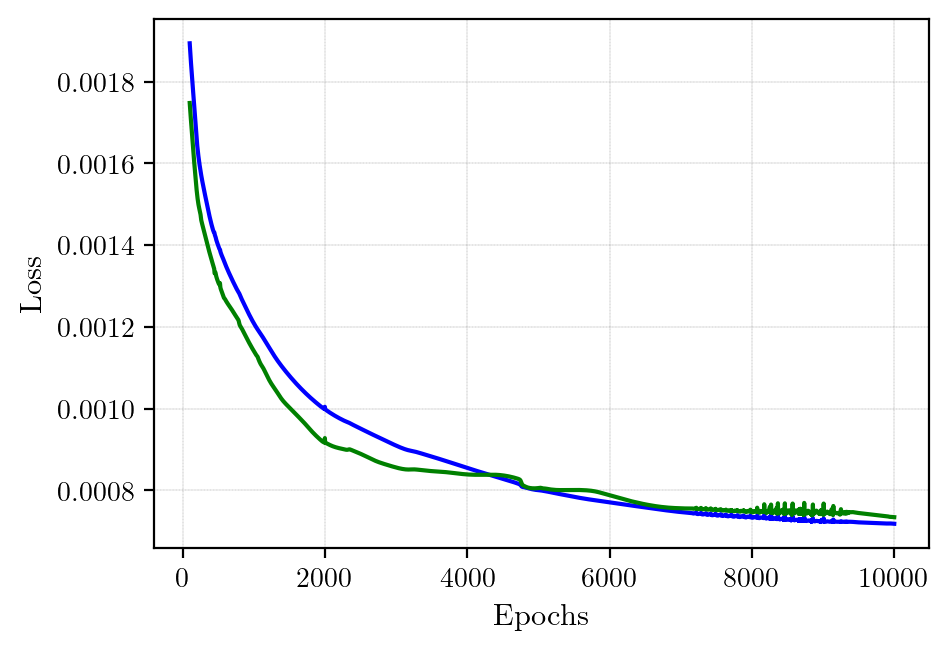

In [6]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [10000]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['activation'] = ['tanh']
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)

df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [10000]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['PINN_flag'] = ['gradient']
config['activation'] = ['tanh']
config['mixed_precision'] = [False]
pipeline(df_file, config)

 0.00095 	 Time: 1.530
Epoch: 6830 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.559
Epoch: 6840 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.537
Epoch: 6850 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.556
Epoch: 6860 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.559
Epoch: 6870 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.539
Epoch: 6880 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.560
Epoch: 6890 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.514
Epoch: 6900 	 Loss: 0.00096 	 Val Loss 0.00094 	 Time: 1.558
Epoch: 6910 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.537
Epoch: 6920 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.553
Epoch: 6930 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.551
Epoch: 6940 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.532
Epoch: 6950 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.563
Epoch: 6960 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.536
Epoch: 6970 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.568
Epoch: 6980 	 Loss: 0.00096 	 Val Loss 0.00095 	 Time: 1.541
E

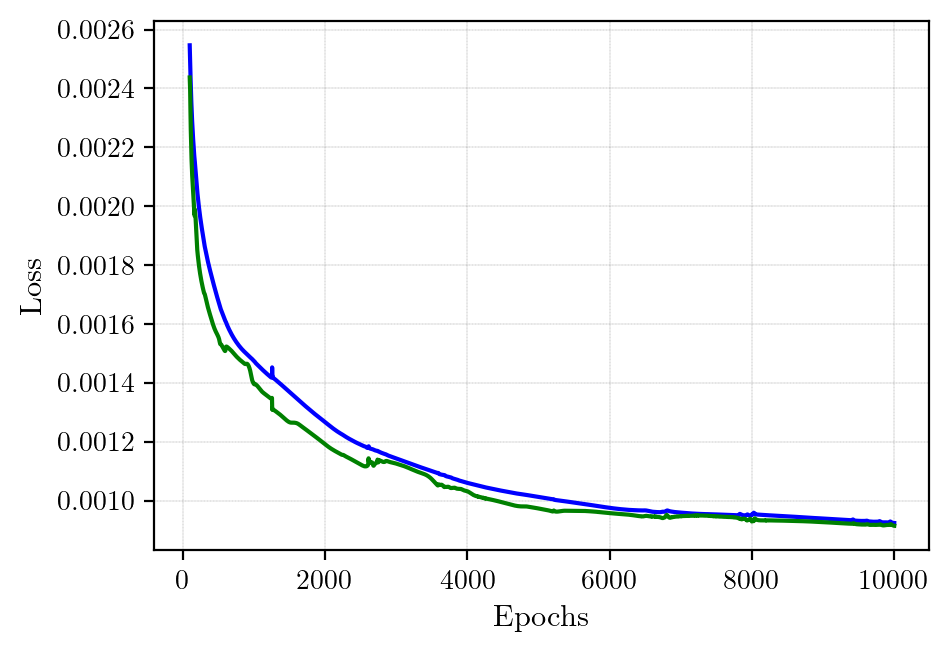

In [15]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [10000]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['activation'] = [bent_identity]
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)


df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [10000]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['PINN_flag'] = ['gradient']
config['activation'] = [bent_identity]
config['mixed_precision'] = [False]
pipeline(df_file, config)

In [ ]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [10000]
config['layers'] = [[3, 40, 40, 40, 40, 40, 40, 40, 40, 3]]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['activation'] = ['tanh']
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)


df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [10000]
config['layers'] = [[3, 40, 40, 40, 40, 40, 40, 40, 40, 1]]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['PINN_flag'] = ['gradient']
config['activation'] = ['tanh']
config['mixed_precision'] = [False]
pipeline(df_file, config)

df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [10000]
config['layers'] = [[3, 40, 40, 40, 40, 40, 40, 40, 40, 3]]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['activation'] = [leaky_relu(act_slope=0.05)]
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)


# #config = get_fast_earth_pinn_config()
# config = get_fast_earth_pinn_config()
# config['epochs'] = [10000]
# config['layers'] = [[3, 40, 40, 40, 40, 40, 40, 40, 40, 1]]
# config['batch_size'] = [2048]
# config['N_train'] = [95000]
# config['PINN_flag'] = ['gradient']
# config['activation'] = [leaky_relu(act_slope=0.05)]
# config['mixed_precision'] = [False]
# pipeline(df_file, config)

df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [10000]
config['layers'] = [[3, 40, 40, 40, 40, 40, 40, 40, 40, 3]]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['activation'] = [bent_identity]
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)


df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\leaky_relu.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [10000]
config['layers'] = [[3, 40, 40, 40, 40, 40, 40, 40, 40, 1]]
config['batch_size'] = [2048]
config['N_train'] = [95000]
config['PINN_flag'] = ['gradient']
config['activation'] = [bent_identity]
config['mixed_precision'] = [False]
pipeline(df_file, config)




In [16]:
results = pd.read_pickle(df_file)

In [17]:
results.keys

<bound method NDFrame.keys of                           Brillouin_max_error  Brillouin_param_rse_mean  \
timetag                                                                   
Tue Feb 16 22:08:39 2021             0.006222                      21.0   
Tue Feb 16 22:32:40 2021             0.006125                      -1.0   
Tue Feb 16 22:52:11 2021             0.006158                      33.0   
Tue Feb 16 23:17:11 2021             0.006142                      46.0   
Tue Feb 16 23:45:03 2021             0.006179                      21.0   
Wed Feb 17 00:13:31 2021             0.006147                      33.0   

                          Brillouin_param_rse_median  \
timetag                                                
Tue Feb 16 22:08:39 2021                        20.0   
Tue Feb 16 22:32:40 2021                        -1.0   
Tue Feb 16 22:52:11 2021                        26.0   
Tue Feb 16 23:17:11 2021                        35.0   
Tue Feb 16 23:45:03 2021         